<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/tp2/7506R_TP2_GRUPO06_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import pandas as pd
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
'''df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

df_train = df_train_original.copy()
df_test = df_test_original.copy()'''

"df_train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')\ndf_test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')\n\ndf_train = df_train_original.copy()\ndf_test = df_test_original.copy()"

# Preprocesamiento del dataset.

En esta notebook nos encargamos de efectuar la limpieza de dataset, la detección de datos incorrectos y/o vacíos, outliers, todo aquello que pueda imposibilitarnos a usar los modelos propuestos.

In [ ]:
#df_train.info()

Podemos ver que el dataset train no tiene datos faltantes.

In [ ]:
#df_train[df_train.duplicated(keep=False)]

Tampoco tiene filas duplicadas.

In [ ]:
#df_test.info()

In [ ]:
#df_test[df_test.duplicated(keep=False)]

El mismo resultado para test.

# Naive Bayes
Es un método de aprendizaje supervisado basado en la aplicación del teorema de Bayes con el supuesto "ingenuo" de independencia condicional entre cada par de características dado el valor de la variable de clase.
Según bayes si tengo un conjunto de clase C y para un documento D, si encuentro una clase que maximice su probabilidad condicional, entonces el documento pertenece a esa clase.

## Objetivo
- Dado un determinado numero de documentos de criticas sobre películas, determinar para cada documento si la crítica es positiva o negativa

## Descripción de los datos
- **ID:** Identificador unico de cada review
- **review_es:** Documento que contiene la crítica
- **sentimiento:** Clases la cual pertenece una crítica la misma puede ser POSITIVA o NEGATIVA

In [ ]:
cinema_review = pd.read_csv('train.csv')
cinema_review

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


## Separación de datos
### Generación de conjunto de test y train

In [ ]:
X = cinema_review.review_es
y = cinema_review.sentimiento
X_train_review, X_test_review, y_train_sentimiento, y_test_sentimiento = train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)

#### Textos de entranamiento

In [ ]:
X_train_review

47808    Cogí esta pequeña joya totalmente por accident...
20154    No puedo creer que me permita a esta película ...
43069    * ¡Alerta de spoiler! * Solo me pone el nervio...
19413    Si hay una cosa que he aprendido de ver el crí...
13673    Recuerdo cuando esto estaba en los teatros, di...
                               ...                        
31092    Es la década de 1920.Y un hombre llamado Walt ...
22917    El primer (y único) tiempo que vi "Sombras" fu...
47481    Esta fue una pérdida de tiempo.PELIGRO: Si lo ...
35597    Esto es, con mucho, el cine indio de la pelícu...
27491    Esta película para siempre dejó una impresión ...
Name: review_es, Length: 40000, dtype: object

In [ ]:
y_train_sentimiento

47808    positivo
20154    negativo
43069    negativo
19413    negativo
13673    negativo
           ...   
31092    positivo
22917    negativo
47481    negativo
35597    negativo
27491    negativo
Name: sentimiento, Length: 40000, dtype: object

**Antes de comenzar a realizar las predicciones es necesario realizar las feature engineer, que permitan sacar el ruido que puedan tener los datos y que esto no influya en el modelo que clasifica las críticas**

## Feature Engineer
### Normalización
Para cada texto del dataFrame vamos a extraer todos los caracteres distintos a letras y números, para disminuir la introducción de ruidos al modelo de NaiveBayes

In [ ]:
for indice in range(0, len(X_train_review)):
    X_train_review.iloc[indice] = unicodedata.normalize("NFKD", X_train_review.iloc[indice]).encode("ascii","ignore").decode("ascii")
X_train_review

47808    Cogi esta pequena joya totalmente por accident...
20154    No puedo creer que me permita a esta pelicula ...
43069    * Alerta de spoiler! * Solo me pone el nervio ...
19413    Si hay una cosa que he aprendido de ver el cri...
13673    Recuerdo cuando esto estaba en los teatros, di...
                               ...                        
31092    Es la decada de 1920.Y un hombre llamado Walt ...
22917    El primer (y unico) tiempo que vi "Sombras" fu...
47481    Esta fue una perdida de tiempo.PELIGRO: Si lo ...
35597    Esto es, con mucho, el cine indio de la pelicu...
27491    Esta pelicula para siempre dejo una impresion ...
Name: review_es, Length: 40000, dtype: object

## Tokenizar y vectorizar documentos para el entrenamiento del modelo

In [ ]:
count_vect = CountVectorizer(
    min_df=30,
    ngram_range=(1,2),
    analyzer='word'
)
X_train_review_count = count_vect.fit_transform(X_train_review)
X_train_review_count.shape

(40000, 43829)

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_review_tfidf = tfidf_transformer.fit_transform(X_train_review_count)
X_train_review_tfidf .shape

(40000, 43829)

## Entrenar clasificador

In [ ]:
clf_naive_bayes = MultinomialNB(alpha=1).fit(X_train_review_tfidf, y_train_sentimiento)

## Realizar predicción con el conjunto de entrenamiento

In [ ]:
X_test_review_count = count_vect.transform(X_test_review)
X_test_review_tfidf = tfidf_transformer.fit_transform(X_test_review_count)
predicted = clf_naive_bayes.predict(X_test_review_tfidf)
predicted

array(['negativo', 'positivo', 'positivo', ..., 'negativo', 'positivo',
       'positivo'], dtype='<U8')

## Evaluación del Modelo

              precision    recall  f1-score   support

    negativo       0.87      0.84      0.85      5000
    positivo       0.84      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


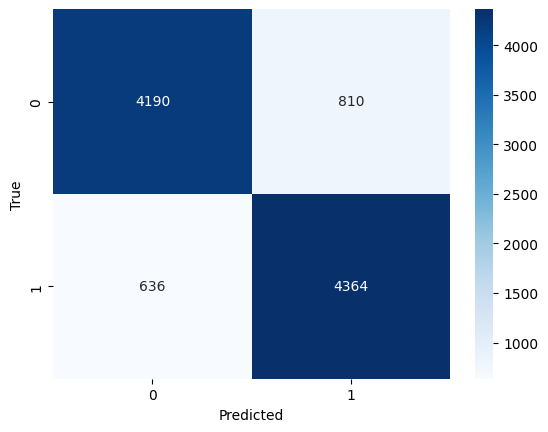

In [ ]:
tabla_confusion=confusion_matrix(y_test_sentimiento,predicted)
sns.heatmap(tabla_confusion, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print(metrics.classification_report(y_test_sentimiento, predicted))

## Cross-validation

In [ ]:
clf_naive_bayes = MultinomialNB(alpha=1).fit(X_train_review_tfidf, y_train_sentimiento)
scores_cv_nb = cross_val_score(clf_naive_bayes,
                               X_train_review_tfidf,
                               y_train_sentimiento,
                               cv = 10,
                               scoring='f1_macro'
)
print("f-score=",round(scores_cv_nb.mean(),4))

f-score= 0.8621


# Predicción con los datos de test.csv

In [ ]:
test = pd.read_csv('test.csv')
X_test_counts_cinema = count_vect.transform(test.review_es)
X_new_tfidf_cinema_test = tfidf_transformer.transform(X_test_counts_cinema)

predicted_cinema = clf_naive_bayes.predict(X_new_tfidf_cinema_test)
predicted_cinema

array(['negativo', 'negativo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype='<U8')

# Exportar datos para kaggle

In [ ]:
csv_nuevo_solution = pd.DataFrame(predicted_cinema)
csv_nuevo_solution["ID"] = np.arange(60000,(8599+60000),1)
csv_nuevo_solution.columns = ['sentimiento', 'ID']
csv_nuevo = csv_nuevo_solution.reindex(['ID', 'sentimiento'], axis=1)
csv_nuevo.to_csv('solution_naive_bayes_final.csv',sep=',', index=False)

# Random Forest

## Division de los datos

In [ ]:
X = cinema_review.review_es
y = cinema_review.sentimiento
X_train_review, X_test_review, y_train_sentimiento, y_test_sentimiento = train_test_split(X,y,stratify=y,test_size=0.20,random_state=42)

# Bag of words

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

## Feature Engineer

In [ ]:
def preprocess_text(text):
    # tokenizacion
    tokens = word_tokenize(text.lower())
    # elimino signos de puntuación
    tokens = [word for word in tokens if word not in string.punctuation]
    # elimino stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

X_train_review = X_train_review.apply(preprocess_text)
X_test_review = X_test_review.apply(preprocess_text)
X_train_review

47808    cogí pequeña joya totalmente accidente 1980 '8...
20154    puedo creer permita película lograr favor amig...
43069    ¡alerta spoiler solo pone nervio personas reha...
19413    si cosa aprendido ver crío george romero si tr...
13673    recuerdo teatros dijo dijo horrible.bueno pens...
                               ...                        
31092    década 1920.y hombre llamado walt disney misió...
22917    primer único tiempo vi `` sombras '' snakpreve...
47481    pérdida tiempo.peligro si ves sentirá tentado ...
35597    cine indio película patético cualquier cine pr...
27491    película siempre dejó impresión mí.lo vi estud...
Name: review_es, Length: 40000, dtype: object

## Tokenizar y vectorizar documentos para el entrenamiento del modelo

In [ ]:
count_vect = CountVectorizer(
    min_df=5,
    ngram_range=(1,2),
    analyzer='word'
)
X_train_review_count = count_vect.fit_transform(X_train_review)
X_train_review_count

<40000x153999 sparse matrix of type '<class 'numpy.int64'>'
	with 5714595 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_review_tfidf = tfidf_transformer.fit_transform(X_train_review_count)
X_train_review_tfidf.shape

(40000, 153999)

Utilizo Random Search CV para la búsqueda de los mejores hiperparámetros.

*   n_estimators: la cantidad de árboles que utilizará Random Forest.
*   criterion: criterio de decisión.
*   min_samples_leaf: el número de muestras mínimas para ser considerada una hoja.
*   min_samples_split: el número mínimo de muestras para dividir un nodo.

In [ ]:
random_forest = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 12, 16],
               "n_estimators": [10,20, 50] }

randomized_search =  RandomizedSearchCV(estimator=random_forest,
                              param_distributions = param_grid,
                              scoring="accuracy",
                              cv=15,
                              n_iter=1)
rs_fit = randomized_search.fit(X_train_review_tfidf, y_train_sentimiento)

### Mejores Parametros

In [ ]:
rs_fit.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'criterion': 'entropy'}

### Accuracy

In [ ]:
print("accuracy en entrenamiento con cv: "+str(rs_fit.best_score_))

accuracy en entrenamiento con cv: 0.7951748717081781


Utilizaremos el dataset de validación para verificar qué tan bien le va a nuestro modelo con datos nuevos.

In [ ]:
X_test_review_count = count_vect.transform(X_test_review)
X_test_review_tfidf = tfidf_transformer.fit_transform(X_test_review_count)
best_model = rs_fit.best_estimator_
predicted = best_model.predict(X_test_review_tfidf)

## Evaluación del Modelo

              precision    recall  f1-score   support

    negativo       0.80      0.81      0.81      5000
    positivo       0.81      0.80      0.80      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000


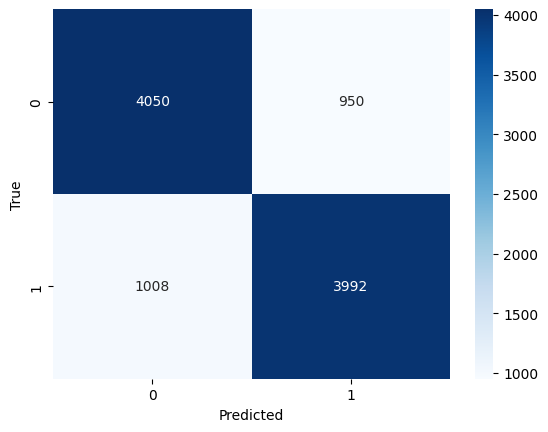

In [ ]:
tabla_confusion=confusion_matrix(y_test_sentimiento,predicted)
sns.heatmap(tabla_confusion, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print(metrics.classification_report(y_test_sentimiento, predicted))

## Predicción con los datos de prueba

In [ ]:
test = pd.read_csv('test.csv')
X_test_counts_cinema = count_vect.transform(test.review_es)
X_new_tfidf_cinema_test = tfidf_transformer.transform(X_test_counts_cinema)

predicted_cinema = best_model.predict(X_new_tfidf_cinema_test)
predicted_cinema

array(['negativo', 'negativo', 'negativo', ..., 'positivo', 'negativo',
       'negativo'], dtype=object)

## Exportar Resultados a kaggle

In [ ]:
csv_nuevo_solution = pd.DataFrame(predicted_cinema)
csv_nuevo_solution["ID"] = np.arange(60000,(8599+60000),1)
csv_nuevo_solution.columns = ['sentimiento', 'ID']
csv_nuevo = csv_nuevo_solution.reindex(['ID', 'sentimiento'], axis=1)
csv_nuevo.to_csv('solution_random_forest_final.csv',sep=',', index=False)

# Ensamble

In [ ]:
!pip install scikit-learn
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv/train.csv')
train_df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv/test.csv')
test_df.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


In [ ]:
pd.reset_option("display.min_rows")
pd.reset_option("display.max_colwidth")

In [ ]:
token_train_df = train_df.copy()
token_test_df = test_df.copy()

def preprocess_text(text):
    # Llevo texto a minúsculas
    text = text.lower()

    # Expresión regular para eliminar caracteres '¿', '¡', y '`'
    text = re.sub(r'[¡¿\`\']', ' ', text)

    # Expresión regular para separar palabras con puntos intermedios
    text = re.sub(r'([\wáéíóúü]+)\.+([\wáéíóúü]+)', r'\1 \2', text)

    # Tokenizacion
    tokens = word_tokenize(text, language='spanish')

    # Elimino signos de puntuación
    tokens = [word for word in tokens if word.isalpha()]

    # global_tokens.extend(tokens) # DEBUG
    return " ".join(tokens)

token_train_df['review_es'] = train_df['review_es'].apply(preprocess_text)
token_test_df['review_es'] = test_df['review_es'].apply(preprocess_text)

In [ ]:
# Cargo las stopwords del corpus de NLTK
stoplist = stopwords.words('spanish')
stoplist_eng = stopwords.words('english')

# Tokenizo el stoplist con el mismo tokenizador del corpus principal
stoplist_tokenized = []
for w in (stoplist + stoplist_eng):
    stoplist_tokenized = stoplist_tokenized + word_tokenize(w)

# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_df['review_es'])
y = train_df['sentimiento'].map({'positivo': 1, 'negativo': 0})

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Obtener los hiperparámetros
params = nb_model.get_params()

# Imprimir los hiperparámetros
print(params)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Obtener los hiperparámetros
params = rf_model.get_params()

# Imprimir los hiperparámetros
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Obtener los hiperparámetros
params = xgb_model.get_params()

# Imprimir los hiperparámetros
print(params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


In [ ]:
def create_nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn_model = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=1)
nn_model._estimator_type = "classifier"
nn_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 352ms/step - accuracy: 0.8291 - loss: 0.3962
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 448s 356ms/step - accuracy: 0.9606 - loss: 0.1086
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 449s 359ms/step - accuracy: 0.9868 - loss: 0.0373
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 497s 356ms/step - accuracy: 0.9941 - loss: 0.0187
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 445s 356ms/step - accuracy: 0.9973 - loss: 0.0099
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 450s 360ms/step - accuracy: 0.9981 - loss: 0.0063
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 500s 359ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 503s 359ms/step - accuracy: 0.9986 - loss: 0.0065
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 514s 369ms/step - accuracy: 0.9969 - loss: 0.0079
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 500s 368ms/step - accuracy: 0.9991 - loss: 0.0034


KerasClassifier(
	model=None
	build_fn=<function create_nn_model at 0x7d5fa7f47130>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('nn', nn_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 352ms/step - accuracy: 0.8318 - loss: 0.3897
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 443s 353ms/step - accuracy: 0.9609 - loss: 0.1043
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 353ms/step - accuracy: 0.9867 - loss: 0.0372
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 449s 358ms/step - accuracy: 0.9942 - loss: 0.0201
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 462s 369ms/step - accuracy: 0.9966 - loss: 0.0113
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 487s 357ms/step - accuracy: 0.9972 - loss: 0.0111
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 442s 354ms/step - accuracy: 0.9987 - loss: 0.0051
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 503s 354ms/step - accuracy: 0.9978 - loss: 0.0081
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 500s 353ms/step - accuracy: 0.9982 - loss: 0.0073
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 443s 354ms/step - accuracy: 0.9994 - loss: 0.0015


VotingClassifier(estimators=[('nb', MultinomialNB()),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gro...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('nn',
                              KerasClassifier(batch_size=32, build_fn=<function create_nn_model at 0x7d5fa7f47130>, epochs=10))],
                 voting='soft')

In [ ]:
# Evaluar el stacking model
y_pred = ensemble_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
print(f'Accuracy del modelo: {accuracy}')
print(f'F1 Score del modelo: {f1}')
print(f'Precision del modelo: {precision}')
print(f'Recall del modelo: {recall}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy del modelo: 0.8901
F1 Score del modelo: 0.8907446068197634
Precision del modelo: 0.8924302788844621
Recall del modelo: 0.8890652907322881


In [ ]:
X_test = vectorizer.transform(test_df['review_es'])
test_predictions = ensemble_model.predict(X_test)

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
salida = pd.DataFrame({'ID': test_df['ID'], 'sentimiento': test_predictions})
salida['sentimiento'] = salida['sentimiento'].map({1: 'positivo', 0: 'negativo'})

# Guardar el archivo para subir a Kaggle
salida.to_csv('/content/drive/My Drive/Colab Notebooks/Ensamble.csv', index=False)

In [ ]:
from joblib import dump, load
dump(ensemble_model, 'Ensamble.joblib')

['Ensamble.joblib']